# Level 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # For ResNet
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
train_full = datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

# 80/10 split from training
train_size = 40000
val_size = 10000

train_dataset, val_dataset = random_split(
    train_full, [train_size, val_size]
)

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


In [5]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [14]:
def train_one_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total


def evaluate(model, loader):
    model.eval()
    loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return loss / len(loader), correct / total

In [9]:
epochs = 5

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    t_loss, t_acc = train_one_epoch(model, train_loader)
    v_loss, v_acc = evaluate(model, val_loader)

    train_losses.append(t_loss)
    val_losses.append(v_loss)
    train_accs.append(t_acc)
    val_accs.append(v_acc)

    print(f"Train Acc: {t_acc:.4f} | Val Acc: {v_acc:.4f}")


Epoch 1/5


100%|██████████| 625/625 [03:06<00:00,  3.35it/s]


Train Acc: 0.7428 | Val Acc: 0.7894

Epoch 2/5


100%|██████████| 625/625 [03:07<00:00,  3.33it/s]


Train Acc: 0.7877 | Val Acc: 0.8036

Epoch 3/5


100%|██████████| 625/625 [03:10<00:00,  3.29it/s]


Train Acc: 0.8016 | Val Acc: 0.8016

Epoch 4/5


100%|██████████| 625/625 [03:11<00:00,  3.27it/s]


Train Acc: 0.8101 | Val Acc: 0.8181

Epoch 5/5


100%|██████████| 625/625 [03:11<00:00,  3.26it/s]


Train Acc: 0.8106 | Val Acc: 0.8223


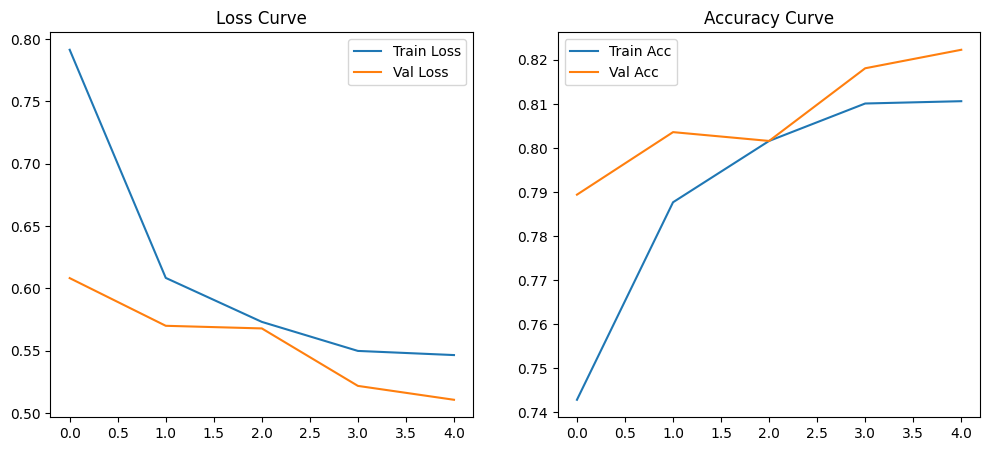

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

In [11]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

✅ Test Accuracy: 82.06%


# Level 2

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [16]:
train_full = datasets.CIFAR10(
    root="./data",
    train=True,
    transform=train_transform,
    download=True
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    transform=val_test_transform,
    download=True
)

train_dataset, val_dataset = random_split(
    train_full, [40000, 10000]
)

In [17]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [18]:
model = models.resnet50(pretrained=True)

# Unfreeze last block
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10
)

In [20]:
epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    t_loss, t_acc = train_one_epoch(model, train_loader)
    v_loss, v_acc = evaluate(model, val_loader)

    scheduler.step()

    train_losses.append(t_loss)
    val_losses.append(v_loss)
    train_accs.append(t_acc)
    val_accs.append(v_acc)

    print(f"Train Acc: {t_acc:.4f} | Val Acc: {v_acc:.4f}")


Epoch 1/10


100%|██████████| 625/625 [05:00<00:00,  2.08it/s]


Train Acc: 0.8441 | Val Acc: 0.8740

Epoch 2/10


100%|██████████| 625/625 [04:44<00:00,  2.20it/s]


Train Acc: 0.9030 | Val Acc: 0.9006

Epoch 3/10


100%|██████████| 625/625 [04:42<00:00,  2.21it/s]


Train Acc: 0.9219 | Val Acc: 0.9170

Epoch 4/10


100%|██████████| 625/625 [04:41<00:00,  2.22it/s]


Train Acc: 0.9391 | Val Acc: 0.9212

Epoch 5/10


100%|██████████| 625/625 [04:46<00:00,  2.18it/s]


Train Acc: 0.9509 | Val Acc: 0.9253

Epoch 6/10


100%|██████████| 625/625 [04:43<00:00,  2.21it/s]


Train Acc: 0.9636 | Val Acc: 0.9280

Epoch 7/10


100%|██████████| 625/625 [04:44<00:00,  2.20it/s]


Train Acc: 0.9721 | Val Acc: 0.9393

Epoch 8/10


100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Train Acc: 0.9817 | Val Acc: 0.9382

Epoch 9/10


100%|██████████| 625/625 [04:44<00:00,  2.19it/s]


Train Acc: 0.9860 | Val Acc: 0.9414

Epoch 10/10


100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Train Acc: 0.9876 | Val Acc: 0.9434


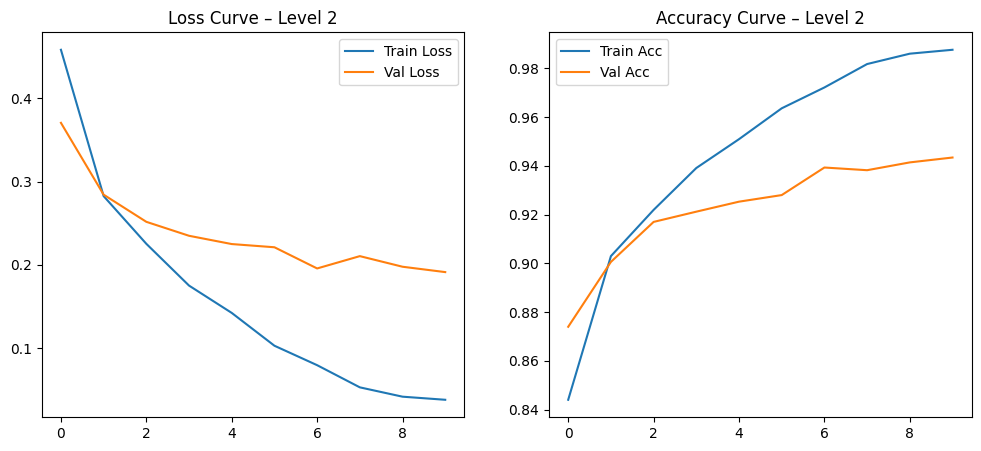

In [21]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve – Level 2")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve – Level 2")

plt.show()

In [22]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"✅ Level-2 Test Accuracy: {test_acc*100:.2f}%")

✅ Level-2 Test Accuracy: 94.64%


# Level 3

In [23]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [24]:
class ResNet50_SE(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        base = models.resnet50(pretrained=True)

        self.features = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool,
            base.layer1,
            base.layer2,
            base.layer3,
            base.layer4
        )

        self.se = SEBlock(2048)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [25]:
model = ResNet50_SE().to(device)

for name, param in model.named_parameters():
    if "features.7" in name or "se" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [26]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=12
)

In [27]:
epochs = 12

for epoch in range(epochs):
    t_loss, t_acc = train_one_epoch(model, train_loader)
    v_loss, v_acc = evaluate(model, val_loader)
    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={t_acc:.4f}, Val Acc={v_acc:.4f}")

100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Epoch 1: Train Acc=0.8443, Val Acc=0.8771


100%|██████████| 625/625 [04:42<00:00,  2.22it/s]


Epoch 2: Train Acc=0.9008, Val Acc=0.9035


100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Epoch 3: Train Acc=0.9220, Val Acc=0.9007


100%|██████████| 625/625 [04:43<00:00,  2.20it/s]


Epoch 4: Train Acc=0.9362, Val Acc=0.9123


100%|██████████| 625/625 [04:43<00:00,  2.21it/s]


Epoch 5: Train Acc=0.9483, Val Acc=0.9231


100%|██████████| 625/625 [04:43<00:00,  2.20it/s]


Epoch 6: Train Acc=0.9603, Val Acc=0.9285


100%|██████████| 625/625 [04:43<00:00,  2.20it/s]


Epoch 7: Train Acc=0.9685, Val Acc=0.9305


100%|██████████| 625/625 [04:43<00:00,  2.20it/s]


Epoch 8: Train Acc=0.9764, Val Acc=0.9326


100%|██████████| 625/625 [04:41<00:00,  2.22it/s]


Epoch 9: Train Acc=0.9815, Val Acc=0.9350


100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Epoch 10: Train Acc=0.9855, Val Acc=0.9368


100%|██████████| 625/625 [04:46<00:00,  2.19it/s]


Epoch 11: Train Acc=0.9905, Val Acc=0.9421


100%|██████████| 625/625 [04:46<00:00,  2.18it/s]


Epoch 12: Train Acc=0.9909, Val Acc=0.9409


In [28]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"✅ Level-3 Test Accuracy: {test_acc*100:.2f}%")

✅ Level-3 Test Accuracy: 94.55%


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1000
           1       0.96      0.97      0.97      1000
           2       0.95      0.93      0.94      1000
           3       0.90      0.89      0.89      1000
           4       0.95      0.94      0.94      1000
           5       0.90      0.91      0.90      1000
           6       0.96      0.96      0.96      1000
           7       0.96      0.97      0.96      1000
           8       0.96      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



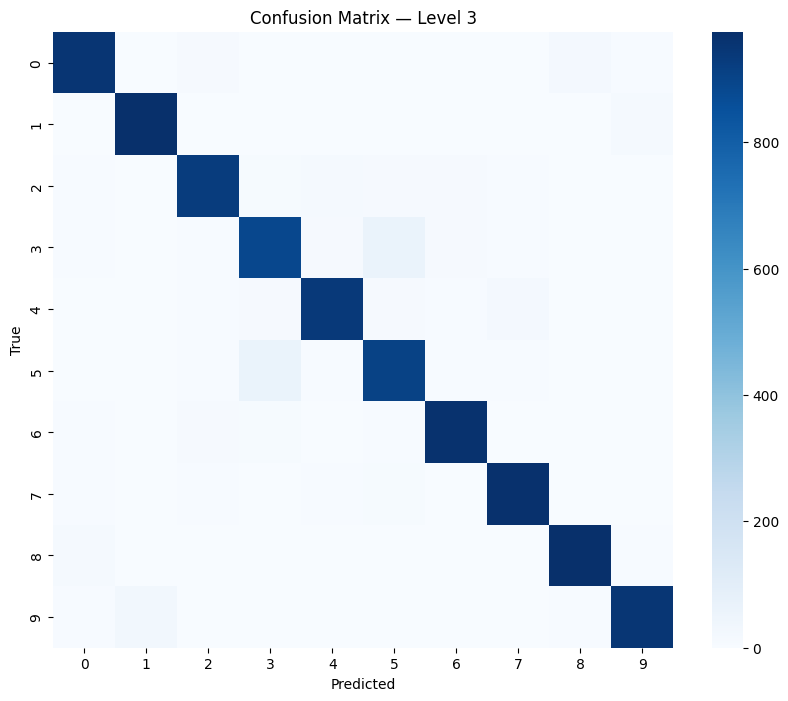

In [30]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix — Level 3")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [31]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=95f6fbae0f11662ddee1cbd864e231892756eb8b316841051646652e7e849667
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [32]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

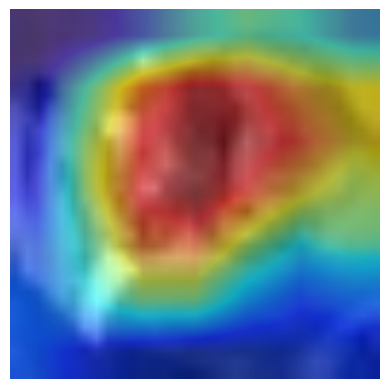

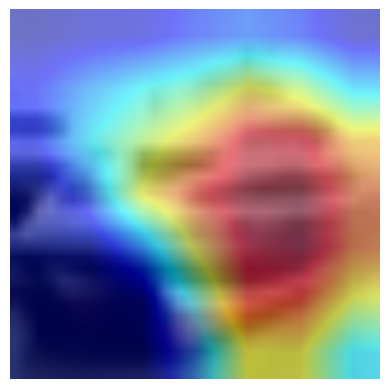

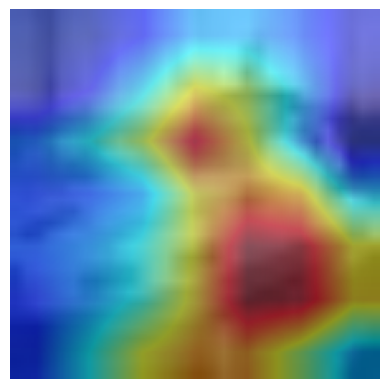

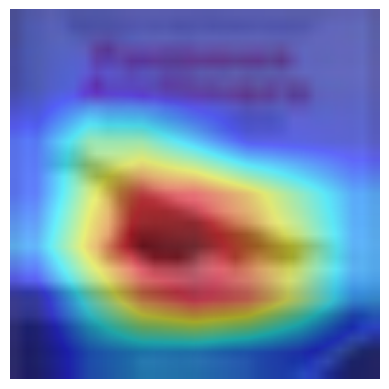

In [33]:
target_layer = model.features[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

images, labels = next(iter(test_loader))
images = images[:4].to(device)
labels = labels[:4]

targets = [ClassifierOutputTarget(l.item()) for l in labels]
grayscale_cam = cam(input_tensor=images, targets=targets)

images_np = images.permute(0,2,3,1).cpu().numpy()
images_np = (images_np - images_np.min()) / (images_np.max() - images_np.min())

for i in range(4):
    visualization = show_cam_on_image(images_np[i], grayscale_cam[i], use_rgb=True)
    plt.imshow(visualization)
    plt.axis("off")
    plt.show()

# Level 4

In [34]:
import timm
import torch.nn as nn

model_eff = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=10
).to(device)

# Freeze early layers
for name, param in model_eff.named_parameters():
    if "classifier" in name or "blocks.6" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [35]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_eff.parameters()),
    lr=3e-4,
    weight_decay=1e-4
)

criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10
)

In [36]:
epochs = 10

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_eff, train_loader)
    val_loss, val_acc = evaluate(model_eff, val_loader)
    scheduler.step()

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

100%|██████████| 625/625 [04:22<00:00,  2.38it/s]


Epoch 1: Train Acc=0.7394, Val Acc=0.8234


100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Epoch 2: Train Acc=0.8451, Val Acc=0.8585


100%|██████████| 625/625 [05:17<00:00,  1.97it/s]


Epoch 3: Train Acc=0.8722, Val Acc=0.8702


100%|██████████| 625/625 [05:11<00:00,  2.01it/s]


Epoch 4: Train Acc=0.8908, Val Acc=0.8772


100%|██████████| 625/625 [05:04<00:00,  2.05it/s]


Epoch 5: Train Acc=0.9052, Val Acc=0.8874


100%|██████████| 625/625 [04:54<00:00,  2.12it/s]


Epoch 6: Train Acc=0.9132, Val Acc=0.8942


100%|██████████| 625/625 [04:57<00:00,  2.10it/s]


Epoch 7: Train Acc=0.9191, Val Acc=0.8948


100%|██████████| 625/625 [05:05<00:00,  2.05it/s]


Epoch 8: Train Acc=0.9227, Val Acc=0.8955


100%|██████████| 625/625 [05:00<00:00,  2.08it/s]


Epoch 9: Train Acc=0.9271, Val Acc=0.8956


100%|██████████| 625/625 [04:53<00:00,  2.13it/s]


Epoch 10: Train Acc=0.9293, Val Acc=0.8972


In [37]:
# Preserving Level-3 SE model
model_se = model
model_se.eval()

model_eff.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [38]:
torch.save(model_se.state_dict(), "resnet50_se_level3.pth")
print("✅ Saved Level-3 SE model")

✅ Saved Level-3 SE model


In [39]:
torch.save(model_eff.state_dict(), "efficientnet_b0_level4.pth")
print("✅ Saved Level-4 EfficientNet model")

✅ Saved Level-4 EfficientNet model


In [40]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

def ensemble_predict(models, loader, weights):
    preds_all, labels_all = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            prob_sum = None
            for model, w in zip(models, weights):
                out = model(images)
                probs = F.softmax(out, dim=1) * w
                prob_sum = probs if prob_sum is None else prob_sum + probs

            preds = prob_sum.argmax(dim=1).cpu().numpy()
            preds_all.extend(preds)
            labels_all.extend(labels.numpy())

    return preds_all, labels_all

In [42]:
models_ensemble = [model_se, model_eff]
weights = [0.5, 0.5]

In [43]:
preds, labels = ensemble_predict(models_ensemble, test_loader, weights)
ensemble_acc = accuracy_score(labels, preds)

print(f"🔥 Level-4 Ensemble Accuracy: {ensemble_acc*100:.2f}%")

🔥 Level-4 Ensemble Accuracy: 95.11%
